##### Copyright 2018 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a Deep Q Network with TF-Agents on Gold Trading

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction


This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  agent on the Trading environment using the TF-Agents library.

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

It will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


To run this code live, click the 'Run in Google Colab' link above.


## Setup

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass


If you haven't installed the following dependencies, run:

In [3]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q --upgrade tensorflow-probability
!pip install -q tf-agents

'sudo' is not recognized as an internal or external command,
operable program or batch file.
ERROR: Invalid requirement: "'gym==0.10.11'"
ERROR: Invalid requirement: "'imageio==2.4.0'"
ERROR: Invalid requirement: "'pyglet==1.3.2'"


In [4]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
!import pyvirtualdisplay

import tensorflow as tf
import gym_anytrading
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from datetime import datetime

'import' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
tf.compat.v1.enable_v2_behavior()
tf.config.experimental_run_functions_eagerly(False)
# Set up a virtual display for rendering OpenAI gym environments.
# Jimmy. NameError: name 'pyvirtualdisplay' is not defined
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [6]:
tf.version.VERSION

'2.1.0'

## Hyperparameters

In [7]:
num_iterations = 20000 # @param {type:"integer"}

collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 10000  #100000 @param {type:"integer"}

batch_size = 1 #64*100  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}


num_eval_episodes = 1  # 10   # @param {type:"integer"}
eval_interval = 1000   #1000 @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite. 

In [8]:
import gym_anytrading
env_name = 'j6fxtrading-v0'
env = suite_gym.load(env_name, max_episode_steps=0)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

In [9]:
#@test {"skip": true}
env.reset()
# Jimmy. Error
#PIL.Image.fromarray(env.render())

TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[ 1.5047e+03,  0.0000e+00],
       [ 1.5048e+03,  1.0000e-01],
       [ 1.5046e+03, -2.0000e-01],
       [ 1.5048e+03,  2.0000e-01],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5049e+03,  1.0000e-01],
       [ 1.5046e+03, -3.0000e-01],
       [ 1.5044e+03, -2.0000e-01],
       [ 1.5043e+03, -1.0000e-01],
       [ 1.5043e+03,  0.0000e+00],
       [ 1.5042e+03, -1.0000e-01],
       [ 1.5041e+03, -1.0000e-01],
       [ 1.5042e+03,  1.0000e-01],
       [ 1.5041e+03, -1.0000e-01],
       [ 1.5038e+03, -3.0000e-01],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5039e+03,  1.0000e-01],
       [ 1.5039e+03,  0.0000e+00],
       [ 1.5037e+03, -2.0000e-01],
       [ 1.5036e

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.



In [10]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(120, 2), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [11]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [12]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"


In [13]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[ 1.5047e+03,  0.0000e+00],
       [ 1.5048e+03,  1.0000e-01],
       [ 1.5046e+03, -2.0000e-01],
       [ 1.5048e+03,  2.0000e-01],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5048e+03,  0.0000e+00],
       [ 1.5049e+03,  1.0000e-01],
       [ 1.5046e+03, -3.0000e-01],
       [ 1.5044e+03, -2.0000e-01],
       [ 1.5043e+03, -1.0000e-01],
       [ 1.5043e+03,  0.0000e+00],
       [ 1.5042e+03, -1.0000e-01],
       [ 1.5041e+03, -1.0000e-01],
       [ 1.5042e+03,  1.0000e-01],
       [ 1.5041e+03, -1.0000e-01],
       [ 1.5038e+03, -3.0000e-01],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5038e+03,  0.0000e+00],
       [ 1.5039e+03,  1.0000e-01],
       [ 1.5039e+03,  0.0000e+00],
       [ 1.5037e+03, -2.0000e-01],
     

Usually two environments are instantiated: one for training and one for evaluation. 

In [14]:
train_py_env = suite_gym.load(env_name, max_episode_steps=0)
eval_py_env = suite_gym.load(env_name, max_episode_steps=0)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [15]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.



In [16]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [17]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.










In [18]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [19]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [20]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load(env_name, max_episode_steps=0))

In [21]:
time_step = example_environment.reset()

In [22]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [23]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

#     while not time_step.is_last():
    for _ in range(1000):
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [24]:
# Jimmy. not for random_policy
#compute_avg_return(eval_env, random_policy, num_eval_episodes)

## Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.



In [25]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [26]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(120, 2), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [27]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [28]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)
#def collect_data(env, policy, buffer):
#  while(~env.current_time_step().is_last()):
#    collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer, steps=batch_size)

#print("Current Time =", datetime.now())
#for _ in range(no_episod_init_replay):
#  train_env.reset()  
#  collect_data(train_env, random_policy, replay_buffer)
#  print("Current Time =", datetime.now())

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial

The replay buffer is now a collection of Trajectories.

In [29]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
#print(iter(replay_buffer.as_dataset()).next())

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [30]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=16* 3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(1, 2), observation=(1, 2, 120, 2), action=(1, 2), policy_info=(), next_step_type=(1, 2), reward=(1, 2), discount=(1, 2)), BufferInfo(ids=(1, 2), probabilities=(1,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [31]:
iterator = iter(dataset)

print(iterator)



In [32]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

#iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

## Visualization



In [33]:
#@test {"skip": true}
try:
  %%time
except:
  pass


print("Current Time =", datetime.now())

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
#avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
#returns = [avg_return]
returns = []
# print('Evaluate avg_return = {0}'.format(avg_return))
print("Current Time =", datetime.now())

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('Time = {0}, step = {1}: loss = {2}'.format(datetime.now(), step, train_loss))
  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('Evaluate Time = {0}, step = {1}: Average Return = {2}'.format(datetime.now(), step, avg_return))
    returns.append(avg_return)


Current Time = 2020-05-07 11:28:40.257624
Current Time = 2020-05-07 11:28:40.257624
Trade - price_diff=-0.09999999999990905 current_price=1507.0 last_trade_price=1507.1 action=1
Trade - price_diff=0.20000000000004547 current_price=1507.2 last_trade_price=1507.0 action=0
Trade - price_diff=-2.0 current_price=1505.2 last_trade_price=1507.2 action=1
Trade - price_diff=-0.10000000000013642 current_price=1505.1 last_trade_price=1505.2 action=0
Trade - price_diff=-0.7999999999999545 current_price=1504.3 last_trade_price=1505.1 action=1
Trade - price_diff=0.10000000000013642 current_price=1504.4 last_trade_price=1504.3 action=0
Trade - price_diff=0.8999999999998636 current_price=1505.3 last_trade_price=1504.4 action=1
Trade - price_diff=-0.599999999999909 current_price=1504.7 last_trade_price=1505.3 action=0
Trade - price_diff=2.2000000000000455 current_price=1506.9 last_trade_price=1504.7 action=1
Trade - price_diff=-0.10000000000013642 current_price=1506.8 last_trade_price=1506.9 action=0
T

Trade - price_diff=-0.5 current_price=1508.6 last_trade_price=1509.1 action=1
Trade - price_diff=0.3000000000001819 current_price=1508.9 last_trade_price=1508.6 action=0
Trade - price_diff=-0.8000000000001819 current_price=1508.1 last_trade_price=1508.9 action=1
Trade - price_diff=0.40000000000009095 current_price=1508.5 last_trade_price=1508.1 action=0
Trade - price_diff=-0.7000000000000455 current_price=1507.8 last_trade_price=1508.5 action=1
Trade - price_diff=0.20000000000004547 current_price=1508.0 last_trade_price=1507.8 action=0
Trade - price_diff=0.7999999999999545 current_price=1508.8 last_trade_price=1508.0 action=1
Trade - price_diff=-0.3999999999998636 current_price=1508.4 last_trade_price=1508.8 action=0
Trade - price_diff=0.3999999999998636 current_price=1508.8 last_trade_price=1508.4 action=1
Trade - price_diff=0.10000000000013642 current_price=1508.9 last_trade_price=1508.8 action=0
Trade - price_diff=-1.300000000000182 current_price=1507.6 last_trade_price=1508.9 actio

Trade - price_diff=0.09999999999990905 current_price=1505.1 last_trade_price=1505.0 action=1
Trade - price_diff=0.0 current_price=1505.1 last_trade_price=1505.1 action=0
Trade - price_diff=-0.09999999999990905 current_price=1505.0 last_trade_price=1505.1 action=1
Trade - price_diff=0.09999999999990905 current_price=1505.1 last_trade_price=1505.0 action=0
Trade - price_diff=1.0 current_price=1506.1 last_trade_price=1505.1 action=1
Trade - price_diff=0.0 current_price=1506.1 last_trade_price=1506.1 action=0
Trade - price_diff=-0.09999999999990905 current_price=1506.0 last_trade_price=1506.1 action=1
Trade - price_diff=0.0 current_price=1506.0 last_trade_price=1506.0 action=0
Trade - price_diff=0.0 current_price=1506.0 last_trade_price=1506.0 action=1
Trade - price_diff=0.20000000000004547 current_price=1506.2 last_trade_price=1506.0 action=0
Trade - price_diff=0.8999999999998636 current_price=1507.1 last_trade_price=1506.2 action=1
Trade - price_diff=0.10000000000013642 current_price=150

Trade - price_diff=-2.1000000000001364 current_price=1500.8 last_trade_price=1502.9 action=1
Trade - price_diff=0.6000000000001364 current_price=1501.4 last_trade_price=1500.8 action=0
Trade - price_diff=0.0 current_price=1501.4 last_trade_price=1501.4 action=1
Trade - price_diff=0.09999999999990905 current_price=1501.5 last_trade_price=1501.4 action=0
Trade - price_diff=0.2999999999999545 current_price=1501.8 last_trade_price=1501.5 action=1
Trade - price_diff=0.6000000000001364 current_price=1502.4 last_trade_price=1501.8 action=0
Trade - price_diff=-0.900000000000091 current_price=1501.5 last_trade_price=1502.4 action=1
Trade - price_diff=0.09999999999990905 current_price=1501.6 last_trade_price=1501.5 action=0
Trade - price_diff=-1.3999999999998636 current_price=1500.2 last_trade_price=1501.6 action=1
Trade - price_diff=-0.2999999999999545 current_price=1499.9 last_trade_price=1500.2 action=0
Trade - price_diff=0.1999999999998181 current_price=1500.1 last_trade_price=1499.9 action=

Trade - price_diff=0.40000000000009095 current_price=1500.7 last_trade_price=1500.3 action=1
Trade - price_diff=0.0 current_price=1500.7 last_trade_price=1500.7 action=0
Trade - price_diff=0.7999999999999545 current_price=1501.5 last_trade_price=1500.7 action=1
Trade - price_diff=-0.2999999999999545 current_price=1501.2 last_trade_price=1501.5 action=0
Trade - price_diff=0.20000000000004547 current_price=1501.4 last_trade_price=1501.2 action=1
Trade - price_diff=0.09999999999990905 current_price=1501.5 last_trade_price=1501.4 action=0
Trade - price_diff=-0.20000000000004547 current_price=1501.3 last_trade_price=1501.5 action=1
Trade - price_diff=0.20000000000004547 current_price=1501.5 last_trade_price=1501.3 action=0
Trade - price_diff=-1.2000000000000455 current_price=1500.3 last_trade_price=1501.5 action=1
Trade - price_diff=0.2999999999999545 current_price=1500.6 last_trade_price=1500.3 action=0
Trade - price_diff=0.10000000000013642 current_price=1500.7 last_trade_price=1500.6 act

Trade - price_diff=-0.7999999999999545 current_price=1501.2 last_trade_price=1502.0 action=1
Trade - price_diff=0.7999999999999545 current_price=1502.0 last_trade_price=1501.2 action=0
Trade - price_diff=-0.2999999999999545 current_price=1501.7 last_trade_price=1502.0 action=1
Trade - price_diff=-1.0 current_price=1500.7 last_trade_price=1501.7 action=0
Trade - price_diff=0.20000000000004547 current_price=1500.9 last_trade_price=1500.7 action=1
Trade - price_diff=-0.3000000000001819 current_price=1500.6 last_trade_price=1500.9 action=0
Trade - price_diff=0.0 current_price=1500.6 last_trade_price=1500.6 action=1
Trade - price_diff=0.20000000000004547 current_price=1500.8 last_trade_price=1500.6 action=0
Trade - price_diff=0.20000000000004547 current_price=1501.0 last_trade_price=1500.8 action=1
Trade - price_diff=-0.09999999999990905 current_price=1500.9 last_trade_price=1501.0 action=0
Trade - price_diff=0.09999999999990905 current_price=1501.0 last_trade_price=1500.9 action=1
Trade - 

Trade - price_diff=-0.2999999999999545 current_price=1479.7 last_trade_price=1480.0 action=0
Trade - price_diff=-0.10000000000013642 current_price=1479.6 last_trade_price=1479.7 action=1
Trade - price_diff=0.0 current_price=1479.6 last_trade_price=1479.6 action=0
Trade - price_diff=-0.2999999999999545 current_price=1479.3 last_trade_price=1479.6 action=1
Trade - price_diff=-0.2999999999999545 current_price=1479.0 last_trade_price=1479.3 action=0
Trade - price_diff=0.5 current_price=1479.5 last_trade_price=1479.0 action=1
Trade - price_diff=0.09999999999990905 current_price=1479.6 last_trade_price=1479.5 action=0
Trade - price_diff=-0.09999999999990905 current_price=1479.5 last_trade_price=1479.6 action=1
Trade - price_diff=-0.09999999999990905 current_price=1479.4 last_trade_price=1479.5 action=0
Trade - price_diff=0.599999999999909 current_price=1480.0 last_trade_price=1479.4 action=1
Trade - price_diff=0.09999999999990905 current_price=1480.1 last_trade_price=1480.0 action=0
Trade - 

Trade - price_diff=0.8999999999998636 current_price=1478.1 last_trade_price=1477.2 action=1
Trade - price_diff=-0.09999999999990905 current_price=1478.0 last_trade_price=1478.1 action=0
Trade - price_diff=-0.09999999999990905 current_price=1477.9 last_trade_price=1478.0 action=1
Trade - price_diff=0.0 current_price=1477.9 last_trade_price=1477.9 action=0
Trade - price_diff=-0.10000000000013642 current_price=1477.8 last_trade_price=1477.9 action=1
Trade - price_diff=0.0 current_price=1477.8 last_trade_price=1477.8 action=0
Trade - price_diff=1.2000000000000455 current_price=1479.0 last_trade_price=1477.8 action=1
Trade - price_diff=-0.2999999999999545 current_price=1478.7 last_trade_price=1479.0 action=0
Trade - price_diff=-0.10000000000013642 current_price=1478.6 last_trade_price=1478.7 action=1
Trade - price_diff=0.40000000000009095 current_price=1479.0 last_trade_price=1478.6 action=0
Trade - price_diff=0.7999999999999545 current_price=1479.8 last_trade_price=1479.0 action=1
Trade - 

Trade - price_diff=0.40000000000009095 current_price=1483.4 last_trade_price=1483.0 action=0
Trade - price_diff=-0.6000000000001364 current_price=1482.8 last_trade_price=1483.4 action=1
Trade - price_diff=0.2999999999999545 current_price=1483.1 last_trade_price=1482.8 action=0
Trade - price_diff=0.20000000000004547 current_price=1483.3 last_trade_price=1483.1 action=1
Trade - price_diff=0.10000000000013642 current_price=1483.4 last_trade_price=1483.3 action=0
Trade - price_diff=0.2999999999999545 current_price=1483.7 last_trade_price=1483.4 action=1
Trade - price_diff=0.20000000000004547 current_price=1483.9 last_trade_price=1483.7 action=0
Trade - price_diff=0.09999999999990905 current_price=1484.0 last_trade_price=1483.9 action=1
Trade - price_diff=-0.599999999999909 current_price=1483.4 last_trade_price=1484.0 action=0
Trade - price_diff=-1.2000000000000455 current_price=1482.2 last_trade_price=1483.4 action=1
Trade - price_diff=0.20000000000004547 current_price=1482.4 last_trade_pr

Trade - price_diff=0.09999999999990905 current_price=1467.0 last_trade_price=1466.9 action=0
Trade - price_diff=0.09999999999990905 current_price=1467.1 last_trade_price=1467.0 action=1
Trade - price_diff=-0.2999999999999545 current_price=1466.8 last_trade_price=1467.1 action=0
Trade - price_diff=0.2999999999999545 current_price=1467.1 last_trade_price=1466.8 action=1
Trade - price_diff=-0.09999999999990905 current_price=1467.0 last_trade_price=1467.1 action=0
Trade - price_diff=0.09999999999990905 current_price=1467.1 last_trade_price=1467.0 action=1
Trade - price_diff=0.10000000000013642 current_price=1467.2 last_trade_price=1467.1 action=0
Trade - price_diff=0.7000000000000455 current_price=1467.9 last_trade_price=1467.2 action=1
Trade - price_diff=-0.10000000000013642 current_price=1467.8 last_trade_price=1467.9 action=0
Trade - price_diff=-1.7999999999999545 current_price=1466.0 last_trade_price=1467.8 action=1
Trade - price_diff=-1.599999999999909 current_price=1464.4 last_trade_

Trade - price_diff=-0.10000000000013642 current_price=1468.3 last_trade_price=1468.4 action=1
Trade - price_diff=0.40000000000009095 current_price=1468.7 last_trade_price=1468.3 action=0
Trade - price_diff=1.2999999999999545 current_price=1470.0 last_trade_price=1468.7 action=1
Trade - price_diff=0.20000000000004547 current_price=1470.2 last_trade_price=1470.0 action=0
Trade - price_diff=0.09999999999990905 current_price=1470.3 last_trade_price=1470.2 action=1
Trade - price_diff=0.10000000000013642 current_price=1470.4 last_trade_price=1470.3 action=0
Trade - price_diff=0.1999999999998181 current_price=1470.6 last_trade_price=1470.4 action=1
Trade - price_diff=0.3000000000001819 current_price=1470.9 last_trade_price=1470.6 action=0
Trade - price_diff=-0.7000000000000455 current_price=1470.2 last_trade_price=1470.9 action=1
Trade - price_diff=0.0 current_price=1470.2 last_trade_price=1470.2 action=0
Trade - price_diff=0.7000000000000455 current_price=1470.9 last_trade_price=1470.2 actio

Trade - price_diff=-2.7999999999999545 current_price=1464.9 last_trade_price=1467.7 action=1
Trade - price_diff=0.8999999999998636 current_price=1465.8 last_trade_price=1464.9 action=0
Trade - price_diff=1.0 current_price=1466.8 last_trade_price=1465.8 action=1
Trade - price_diff=0.40000000000009095 current_price=1467.2 last_trade_price=1466.8 action=0
Trade - price_diff=1.7999999999999545 current_price=1469.0 last_trade_price=1467.2 action=1
Trade - price_diff=0.5 current_price=1469.5 last_trade_price=1469.0 action=0
Trade - price_diff=0.5 current_price=1470.0 last_trade_price=1469.5 action=1
Trade - price_diff=0.599999999999909 current_price=1470.6 last_trade_price=1470.0 action=0
Trade - price_diff=-0.1999999999998181 current_price=1470.4 last_trade_price=1470.6 action=1
Trade - price_diff=0.599999999999909 current_price=1471.0 last_trade_price=1470.4 action=0
Trade - price_diff=0.2999999999999545 current_price=1471.3 last_trade_price=1471.0 action=1
Trade - price_diff=-0.3999999999

Trade - price_diff=0.09999999999990905 current_price=1487.3 last_trade_price=1487.2 action=0
Trade - price_diff=0.0 current_price=1487.3 last_trade_price=1487.3 action=1
Trade - price_diff=0.2999999999999545 current_price=1487.6 last_trade_price=1487.3 action=0
Trade - price_diff=-0.09999999999990905 current_price=1487.5 last_trade_price=1487.6 action=1
Trade - price_diff=-0.09999999999990905 current_price=1487.4 last_trade_price=1487.5 action=0
Trade - price_diff=-0.3000000000001819 current_price=1487.1 last_trade_price=1487.4 action=1
Trade - price_diff=-0.09999999999990905 current_price=1487.0 last_trade_price=1487.1 action=0
Trade - price_diff=-0.7999999999999545 current_price=1486.2 last_trade_price=1487.0 action=1
Trade - price_diff=0.599999999999909 current_price=1486.8 last_trade_price=1486.2 action=0
Trade - price_diff=1.0 current_price=1487.8 last_trade_price=1486.8 action=1
Trade - price_diff=0.6000000000001364 current_price=1488.4 last_trade_price=1487.8 action=0
Trade - pr

Trade - price_diff=0.900000000000091 current_price=1494.5 last_trade_price=1493.6 action=1
Trade - price_diff=0.0 current_price=1494.5 last_trade_price=1494.5 action=0
Trade - price_diff=0.09999999999990905 current_price=1494.6 last_trade_price=1494.5 action=1
Trade - price_diff=0.3000000000001819 current_price=1494.9 last_trade_price=1494.6 action=0
Trade - price_diff=-0.10000000000013642 current_price=1494.8 last_trade_price=1494.9 action=1
Trade - price_diff=0.0 current_price=1494.8 last_trade_price=1494.8 action=0
Trade - price_diff=0.0 current_price=1494.8 last_trade_price=1494.8 action=1
Trade - price_diff=0.0 current_price=1494.8 last_trade_price=1494.8 action=0
Trade - price_diff=-0.20000000000004547 current_price=1494.6 last_trade_price=1494.8 action=1
Trade - price_diff=-0.09999999999990905 current_price=1494.5 last_trade_price=1494.6 action=0
Trade - price_diff=0.599999999999909 current_price=1495.1 last_trade_price=1494.5 action=1
Trade - price_diff=-0.2999999999999545 curr

Trade - price_diff=-0.900000000000091 current_price=1501.0 last_trade_price=1501.9 action=0
Trade - price_diff=-2.2999999999999545 current_price=1498.7 last_trade_price=1501.0 action=1
Trade - price_diff=0.20000000000004547 current_price=1498.9 last_trade_price=1498.7 action=0
Trade - price_diff=-2.5 current_price=1496.4 last_trade_price=1498.9 action=1
Trade - price_diff=0.2999999999999545 current_price=1496.7 last_trade_price=1496.4 action=0
Trade - price_diff=-0.5 current_price=1496.2 last_trade_price=1496.7 action=1
Trade - price_diff=-0.6000000000001364 current_price=1495.6 last_trade_price=1496.2 action=0
Trade - price_diff=-0.3999999999998636 current_price=1495.2 last_trade_price=1495.6 action=1
Trade - price_diff=-1.400000000000091 current_price=1493.8 last_trade_price=1495.2 action=0
Trade - price_diff=1.6000000000001364 current_price=1495.4 last_trade_price=1493.8 action=1
Trade - price_diff=0.5 current_price=1495.9 last_trade_price=1495.4 action=0
Trade - price_diff=-0.20000

Trade - price_diff=1.099999999999909 current_price=1497.8 last_trade_price=1496.7 action=1
Trade - price_diff=0.20000000000004547 current_price=1498.0 last_trade_price=1497.8 action=0
Trade - price_diff=-0.599999999999909 current_price=1497.4 last_trade_price=1498.0 action=1
Trade - price_diff=-0.40000000000009095 current_price=1497.0 last_trade_price=1497.4 action=0
Trade - price_diff=0.0 current_price=1497.0 last_trade_price=1497.0 action=1
Trade - price_diff=0.40000000000009095 current_price=1497.4 last_trade_price=1497.0 action=0
Trade - price_diff=-0.20000000000004547 current_price=1497.2 last_trade_price=1497.4 action=1
Trade - price_diff=-0.2999999999999545 current_price=1496.9 last_trade_price=1497.2 action=0
Time = 2020-05-07 11:30:03.438773, step = 7500: loss = 13924.0
Trade - price_diff=1.099999999999909 current_price=1498.0 last_trade_price=1496.9 action=1
Trade - price_diff=0.599999999999909 current_price=1498.6 last_trade_price=1498.0 action=0
Trade - price_diff=-0.199999

Trade - price_diff=-0.09999999999990905 current_price=1505.7 last_trade_price=1505.8 action=1
Trade - price_diff=0.09999999999990905 current_price=1505.8 last_trade_price=1505.7 action=0
Trade - price_diff=1.1000000000001364 current_price=1506.9 last_trade_price=1505.8 action=1
Time = 2020-05-07 11:30:07.555694, step = 8000: loss = 1040400.0
Trade - price_diff=0.20000000000004547 current_price=1507.3 last_trade_price=1507.1 action=1
Evaluate Time = 2020-05-07 11:30:10.631260, step = 8000: Average Return = -2.0
Trade - price_diff=-0.10000000000013642 current_price=1506.8 last_trade_price=1506.9 action=0
Trade - price_diff=0.40000000000009095 current_price=1507.2 last_trade_price=1506.8 action=1
Trade - price_diff=0.0 current_price=1507.2 last_trade_price=1507.2 action=0
Trade - price_diff=0.20000000000004547 current_price=1507.4 last_trade_price=1507.2 action=1
Trade - price_diff=-0.20000000000004547 current_price=1507.2 last_trade_price=1507.4 action=0
Trade - price_diff=-0.5 current_p

Trade - price_diff=0.0 current_price=1507.4 last_trade_price=1507.4 action=1
Trade - price_diff=0.1999999999998181 current_price=1507.6 last_trade_price=1507.4 action=0
Trade - price_diff=0.5 current_price=1508.1 last_trade_price=1507.6 action=1
Trade - price_diff=0.3000000000001819 current_price=1508.4 last_trade_price=1508.1 action=0
Trade - price_diff=-0.6000000000001364 current_price=1507.8 last_trade_price=1508.4 action=1
Trade - price_diff=-0.3999999999998636 current_price=1507.4 last_trade_price=1507.8 action=0
Trade - price_diff=0.2999999999999545 current_price=1507.7 last_trade_price=1507.4 action=1
Trade - price_diff=0.599999999999909 current_price=1508.3 last_trade_price=1507.7 action=0
Trade - price_diff=1.2000000000000455 current_price=1509.5 last_trade_price=1508.3 action=1
Trade - price_diff=0.2999999999999545 current_price=1509.8 last_trade_price=1509.5 action=0
Trade - price_diff=-0.7999999999999545 current_price=1509.0 last_trade_price=1509.8 action=1
Trade - price_di

Trade - price_diff=0.599999999999909 current_price=1507.1 last_trade_price=1506.5 action=1
Trade - price_diff=0.10000000000013642 current_price=1507.2 last_trade_price=1507.1 action=0
Trade - price_diff=-0.7999999999999545 current_price=1506.4 last_trade_price=1507.2 action=1
Trade - price_diff=1.3999999999998636 current_price=1507.8 last_trade_price=1506.4 action=0
Time = 2020-05-07 11:30:18.807927, step = 9000: loss = 121104.0
Evaluate Time = 2020-05-07 11:30:21.856617, step = 9000: Average Return = 0.0
Trade - price_diff=-0.20000000000004547 current_price=1507.6 last_trade_price=1507.8 action=1
Trade - price_diff=0.20000000000004547 current_price=1507.8 last_trade_price=1507.6 action=0
Trade - price_diff=0.40000000000009095 current_price=1508.2 last_trade_price=1507.8 action=1
Trade - price_diff=0.20000000000004547 current_price=1508.4 last_trade_price=1508.2 action=0
Trade - price_diff=1.199999999999818 current_price=1509.6 last_trade_price=1508.4 action=1
Trade - price_diff=-1.0 c

Trade - price_diff=-0.3000000000001819 current_price=1504.6 last_trade_price=1504.9 action=0
Time = 2020-05-07 11:30:25.946543, step = 9500: loss = 270400.0
Trade - price_diff=0.0 current_price=1504.6 last_trade_price=1504.6 action=1
Trade - price_diff=0.10000000000013642 current_price=1504.7 last_trade_price=1504.6 action=0
Trade - price_diff=-0.10000000000013642 current_price=1504.6 last_trade_price=1504.7 action=1
Trade - price_diff=-0.2999999999999545 current_price=1504.3 last_trade_price=1504.6 action=0
Trade - price_diff=-0.2999999999999545 current_price=1504.0 last_trade_price=1504.3 action=1
Trade - price_diff=-0.09999999999990905 current_price=1503.9 last_trade_price=1504.0 action=0
Trade - price_diff=-0.10000000000013642 current_price=1503.8 last_trade_price=1503.9 action=1
Trade - price_diff=-0.3999999999998636 current_price=1503.4 last_trade_price=1503.8 action=0
Trade - price_diff=-0.20000000000004547 current_price=1503.2 last_trade_price=1503.4 action=1
Trade - price_diff

Trade - price_diff=-0.6000000000001364 current_price=1527.3 last_trade_price=1527.9 action=1
Trade - price_diff=-0.09999999999990905 current_price=1527.2 last_trade_price=1527.3 action=0
Trade - price_diff=0.09999999999990905 current_price=1527.3 last_trade_price=1527.2 action=1
Trade - price_diff=-0.3999999999998636 current_price=1526.9 last_trade_price=1527.3 action=0
Trade - price_diff=0.8999999999998636 current_price=1527.8 last_trade_price=1526.9 action=1
Trade - price_diff=-0.3999999999998636 current_price=1527.4 last_trade_price=1527.8 action=0
Trade - price_diff=0.0 current_price=1527.4 last_trade_price=1527.4 action=1
Trade - price_diff=-0.900000000000091 current_price=1526.5 last_trade_price=1527.4 action=0
Trade - price_diff=1.7000000000000455 current_price=1528.2 last_trade_price=1526.5 action=1
Trade - price_diff=0.599999999999909 current_price=1528.8 last_trade_price=1528.2 action=0
Trade - price_diff=0.7999999999999545 current_price=1529.6 last_trade_price=1528.8 action=

Trade - price_diff=0.0 current_price=1529.2 last_trade_price=1529.2 action=1
Trade - price_diff=0.09999999999990905 current_price=1529.3 last_trade_price=1529.2 action=0
Trade - price_diff=0.2999999999999545 current_price=1529.6 last_trade_price=1529.3 action=1
Trade - price_diff=0.0 current_price=1529.6 last_trade_price=1529.6 action=0
Trade - price_diff=0.20000000000004547 current_price=1529.8 last_trade_price=1529.6 action=1
Trade - price_diff=0.10000000000013642 current_price=1529.9 last_trade_price=1529.8 action=0
Trade - price_diff=-0.3000000000001819 current_price=1529.6 last_trade_price=1529.9 action=1
Trade - price_diff=0.40000000000009095 current_price=1530.0 last_trade_price=1529.6 action=0
Trade - price_diff=0.20000000000004547 current_price=1530.2 last_trade_price=1530.0 action=1
Trade - price_diff=-0.20000000000004547 current_price=1530.0 last_trade_price=1530.2 action=0
Trade - price_diff=-0.40000000000009095 current_price=1529.6 last_trade_price=1530.0 action=1
Trade - 

Trade - price_diff=1.1000000000001364 current_price=1533.2 last_trade_price=1532.1 action=0
Trade - price_diff=0.8999999999998636 current_price=1534.1 last_trade_price=1533.2 action=1
Trade - price_diff=-0.2999999999999545 current_price=1533.8 last_trade_price=1534.1 action=0
Trade - price_diff=0.0 current_price=1533.8 last_trade_price=1533.8 action=1
Trade - price_diff=0.0 current_price=1533.8 last_trade_price=1533.8 action=0
Trade - price_diff=-1.599999999999909 current_price=1532.2 last_trade_price=1533.8 action=1
Trade - price_diff=-0.7000000000000455 current_price=1531.5 last_trade_price=1532.2 action=0
Trade - price_diff=-1.0 current_price=1530.5 last_trade_price=1531.5 action=1
Trade - price_diff=-0.5 current_price=1530.0 last_trade_price=1530.5 action=0
Trade - price_diff=-2.2000000000000455 current_price=1527.8 last_trade_price=1530.0 action=1
Trade - price_diff=-1.2999999999999545 current_price=1526.5 last_trade_price=1527.8 action=0
Trade - price_diff=7.099999999999909 curre

Trade - price_diff=-0.5 current_price=1521.2 last_trade_price=1521.7 action=1
Trade - price_diff=0.09999999999990905 current_price=1521.3 last_trade_price=1521.2 action=0
Trade - price_diff=-0.8999999999998636 current_price=1520.4 last_trade_price=1521.3 action=1
Trade - price_diff=0.3999999999998636 current_price=1520.8 last_trade_price=1520.4 action=0
Trade - price_diff=-0.2999999999999545 current_price=1520.5 last_trade_price=1520.8 action=1
Trade - price_diff=0.0 current_price=1520.5 last_trade_price=1520.5 action=0
Trade - price_diff=0.09999999999990905 current_price=1520.6 last_trade_price=1520.5 action=1
Trade - price_diff=0.20000000000004547 current_price=1520.8 last_trade_price=1520.6 action=0
Trade - price_diff=0.7999999999999545 current_price=1521.6 last_trade_price=1520.8 action=1
Trade - price_diff=-0.1999999999998181 current_price=1521.4 last_trade_price=1521.6 action=0
Trade - price_diff=0.6999999999998181 current_price=1522.1 last_trade_price=1521.4 action=1
Trade - pri

Trade - price_diff=-0.3000000000001819 current_price=1520.6 last_trade_price=1520.9 action=0
Trade - price_diff=0.8000000000001819 current_price=1521.4 last_trade_price=1520.6 action=1
Trade - price_diff=0.0 current_price=1521.4 last_trade_price=1521.4 action=0
Trade - price_diff=0.599999999999909 current_price=1522.0 last_trade_price=1521.4 action=1
Trade - price_diff=0.09999999999990905 current_price=1522.1 last_trade_price=1522.0 action=0
Trade - price_diff=-0.1999999999998181 current_price=1521.9 last_trade_price=1522.1 action=1
Trade - price_diff=-1.0 current_price=1520.9 last_trade_price=1521.9 action=0
Trade - price_diff=0.09999999999990905 current_price=1521.0 last_trade_price=1520.9 action=1
Trade - price_diff=-0.7000000000000455 current_price=1520.3 last_trade_price=1521.0 action=0
Trade - price_diff=-0.20000000000004547 current_price=1520.1 last_trade_price=1520.3 action=1
Trade - price_diff=0.10000000000013642 current_price=1520.2 last_trade_price=1520.1 action=0
Trade - pr

Trade - price_diff=-0.3999999999998636 current_price=1524.9 last_trade_price=1525.3 action=0
Trade - price_diff=0.599999999999909 current_price=1525.5 last_trade_price=1524.9 action=1
Trade - price_diff=-1.099999999999909 current_price=1524.4 last_trade_price=1525.5 action=0
Trade - price_diff=-1.1000000000001364 current_price=1523.3 last_trade_price=1524.4 action=1
Trade - price_diff=0.10000000000013642 current_price=1523.4 last_trade_price=1523.3 action=0
Trade - price_diff=-0.20000000000004547 current_price=1523.2 last_trade_price=1523.4 action=1
Trade - price_diff=0.20000000000004547 current_price=1523.4 last_trade_price=1523.2 action=0
Trade - price_diff=-0.20000000000004547 current_price=1523.2 last_trade_price=1523.4 action=1
Trade - price_diff=0.0 current_price=1523.2 last_trade_price=1523.2 action=0
Trade - price_diff=-0.2999999999999545 current_price=1522.9 last_trade_price=1523.2 action=1
Trade - price_diff=0.0 current_price=1522.9 last_trade_price=1522.9 action=0
Trade - pr

Trade - price_diff=1.400000000000091 current_price=1517.9 last_trade_price=1516.5 action=0
Trade - price_diff=-3.300000000000182 current_price=1514.6 last_trade_price=1517.9 action=1
Trade - price_diff=-0.599999999999909 current_price=1514.0 last_trade_price=1514.6 action=0
Trade - price_diff=-2.0 current_price=1512.0 last_trade_price=1514.0 action=1
Trade - price_diff=-0.20000000000004547 current_price=1511.8 last_trade_price=1512.0 action=0
Trade - price_diff=1.2999999999999545 current_price=1513.1 last_trade_price=1511.8 action=1
Trade - price_diff=0.3000000000001819 current_price=1513.4 last_trade_price=1513.1 action=0
Trade - price_diff=-0.10000000000013642 current_price=1513.3 last_trade_price=1513.4 action=1
Trade - price_diff=0.0 current_price=1513.3 last_trade_price=1513.3 action=0
Trade - price_diff=0.6000000000001364 current_price=1513.9 last_trade_price=1513.3 action=1
Trade - price_diff=0.2999999999999545 current_price=1514.2 last_trade_price=1513.9 action=0
Trade - price_

Trade - price_diff=-0.3999999999998636 current_price=1513.4 last_trade_price=1513.8 action=1
Trade - price_diff=0.0 current_price=1513.4 last_trade_price=1513.4 action=0
Trade - price_diff=-0.20000000000004547 current_price=1513.2 last_trade_price=1513.4 action=1
Trade - price_diff=0.0 current_price=1513.2 last_trade_price=1513.2 action=0
Trade - price_diff=0.09999999999990905 current_price=1513.3 last_trade_price=1513.2 action=1
Trade - price_diff=-0.20000000000004547 current_price=1513.1 last_trade_price=1513.3 action=0
Trade - price_diff=0.20000000000004547 current_price=1513.3 last_trade_price=1513.1 action=1
Trade - price_diff=-0.5 current_price=1512.8 last_trade_price=1513.3 action=0
Trade - price_diff=-0.09999999999990905 current_price=1512.7 last_trade_price=1512.8 action=1
Trade - price_diff=0.3999999999998636 current_price=1513.1 last_trade_price=1512.7 action=0
Trade - price_diff=3.300000000000182 current_price=1516.4 last_trade_price=1513.1 action=1
Trade - price_diff=0.599

Trade - price_diff=-1.400000000000091 current_price=1502.0 last_trade_price=1503.4 action=1
Trade - price_diff=-0.09999999999990905 current_price=1501.9 last_trade_price=1502.0 action=0
Trade - price_diff=-0.8000000000001819 current_price=1501.1 last_trade_price=1501.9 action=1
Trade - price_diff=0.20000000000004547 current_price=1501.3 last_trade_price=1501.1 action=0
Trade - price_diff=-0.599999999999909 current_price=1500.7 last_trade_price=1501.3 action=1
Trade - price_diff=-0.2999999999999545 current_price=1500.4 last_trade_price=1500.7 action=0
Trade - price_diff=-0.40000000000009095 current_price=1500.0 last_trade_price=1500.4 action=1
Trade - price_diff=0.7000000000000455 current_price=1500.7 last_trade_price=1500.0 action=0
Trade - price_diff=0.09999999999990905 current_price=1500.8 last_trade_price=1500.7 action=1
Trade - price_diff=0.20000000000004547 current_price=1501.0 last_trade_price=1500.8 action=0
Trade - price_diff=-0.20000000000004547 current_price=1500.8 last_trade

Trade - price_diff=0.09999999999990905 current_price=1504.0 last_trade_price=1503.9 action=1
Trade - price_diff=0.0 current_price=1504.0 last_trade_price=1504.0 action=0
Trade - price_diff=0.0 current_price=1504.0 last_trade_price=1504.0 action=1
Trade - price_diff=-0.09999999999990905 current_price=1503.9 last_trade_price=1504.0 action=0
Trade - price_diff=0.5 current_price=1504.4 last_trade_price=1503.9 action=1
Trade - price_diff=0.1999999999998181 current_price=1504.6 last_trade_price=1504.4 action=0
Trade - price_diff=0.0 current_price=1504.6 last_trade_price=1504.6 action=1
Trade - price_diff=0.0 current_price=1504.6 last_trade_price=1504.6 action=0
Trade - price_diff=0.40000000000009095 current_price=1505.0 last_trade_price=1504.6 action=1
Trade - price_diff=-0.20000000000004547 current_price=1504.8 last_trade_price=1505.0 action=0
Trade - price_diff=0.0 current_price=1504.8 last_trade_price=1504.8 action=1
Trade - price_diff=0.10000000000013642 current_price=1504.9 last_trade_p

Trade - price_diff=1.1000000000001364 current_price=1498.9 last_trade_price=1497.8 action=1
Trade - price_diff=0.09999999999990905 current_price=1499.0 last_trade_price=1498.9 action=0
Trade - price_diff=0.7999999999999545 current_price=1499.8 last_trade_price=1499.0 action=1
Trade - price_diff=-0.20000000000004547 current_price=1499.6 last_trade_price=1499.8 action=0
Trade - price_diff=0.0 current_price=1499.6 last_trade_price=1499.6 action=1
Trade - price_diff=0.0 current_price=1499.6 last_trade_price=1499.6 action=0
Trade - price_diff=0.900000000000091 current_price=1500.5 last_trade_price=1499.6 action=1
Trade - price_diff=0.0 current_price=1500.5 last_trade_price=1500.5 action=0
Trade - price_diff=-0.09999999999990905 current_price=1500.4 last_trade_price=1500.5 action=1
Trade - price_diff=0.1999999999998181 current_price=1500.6 last_trade_price=1500.4 action=0
Trade - price_diff=-0.7999999999999545 current_price=1499.8 last_trade_price=1500.6 action=1
Trade - price_diff=0.2000000

Trade - price_diff=-0.40000000000009095 current_price=1499.3 last_trade_price=1499.7 action=1
Trade - price_diff=-0.20000000000004547 current_price=1499.1 last_trade_price=1499.3 action=0
Trade - price_diff=-0.1999999999998181 current_price=1498.9 last_trade_price=1499.1 action=1
Trade - price_diff=0.0 current_price=1498.9 last_trade_price=1498.9 action=0
Trade - price_diff=-0.40000000000009095 current_price=1498.5 last_trade_price=1498.9 action=1
Trade - price_diff=-0.09999999999990905 current_price=1498.4 last_trade_price=1498.5 action=0
Trade - price_diff=-1.1000000000001364 current_price=1497.3 last_trade_price=1498.4 action=1
Trade - price_diff=0.10000000000013642 current_price=1497.4 last_trade_price=1497.3 action=0
Trade - price_diff=0.1999999999998181 current_price=1497.6 last_trade_price=1497.4 action=1
Trade - price_diff=-0.1999999999998181 current_price=1497.4 last_trade_price=1497.6 action=0
Trade - price_diff=-1.6000000000001364 current_price=1495.8 last_trade_price=1497.4

Trade - price_diff=-0.20000000000004547 current_price=1492.8 last_trade_price=1493.0 action=0
Trade - price_diff=-0.599999999999909 current_price=1492.2 last_trade_price=1492.8 action=1
Trade - price_diff=0.0 current_price=1492.2 last_trade_price=1492.2 action=0
Trade - price_diff=0.0 current_price=1492.2 last_trade_price=1492.2 action=1
Trade - price_diff=0.3999999999998636 current_price=1492.6 last_trade_price=1492.2 action=0
Trade - price_diff=-0.2999999999999545 current_price=1492.3 last_trade_price=1492.6 action=1
Trade - price_diff=-0.09999999999990905 current_price=1492.2 last_trade_price=1492.3 action=0
Trade - price_diff=-0.10000000000013642 current_price=1492.1 last_trade_price=1492.2 action=1
Trade - price_diff=0.10000000000013642 current_price=1492.2 last_trade_price=1492.1 action=0
Trade - price_diff=0.0 current_price=1492.2 last_trade_price=1492.2 action=1
Trade - price_diff=-0.20000000000004547 current_price=1492.0 last_trade_price=1492.2 action=0
Trade - price_diff=0.29

Trade - price_diff=0.40000000000009095 current_price=1509.2 last_trade_price=1508.8 action=1
Trade - price_diff=0.0 current_price=1509.2 last_trade_price=1509.2 action=0
Trade - price_diff=-0.10000000000013642 current_price=1509.1 last_trade_price=1509.2 action=1
Trade - price_diff=-0.8999999999998636 current_price=1508.2 last_trade_price=1509.1 action=0
Trade - price_diff=0.09999999999990905 current_price=1508.3 last_trade_price=1508.2 action=1
Trade - price_diff=0.10000000000013642 current_price=1508.4 last_trade_price=1508.3 action=0
Trade - price_diff=0.09999999999990905 current_price=1508.5 last_trade_price=1508.4 action=1
Trade - price_diff=-0.20000000000004547 current_price=1508.3 last_trade_price=1508.5 action=0
Trade - price_diff=1.900000000000091 current_price=1510.2 last_trade_price=1508.3 action=1
Trade - price_diff=-0.6000000000001364 current_price=1509.6 last_trade_price=1510.2 action=0
Trade - price_diff=1.0 current_price=1510.6 last_trade_price=1509.6 action=1
Trade - p

Trade - price_diff=0.09999999999990905 current_price=1501.3 last_trade_price=1501.2 action=1
Trade - price_diff=0.0 current_price=1501.3 last_trade_price=1501.3 action=0
Trade - price_diff=0.10000000000013642 current_price=1501.4 last_trade_price=1501.3 action=1
Trade - price_diff=0.1999999999998181 current_price=1501.6 last_trade_price=1501.4 action=0
Trade - price_diff=0.10000000000013642 current_price=1501.7 last_trade_price=1501.6 action=1
Trade - price_diff=-0.10000000000013642 current_price=1501.6 last_trade_price=1501.7 action=0
Trade - price_diff=0.20000000000004547 current_price=1501.8 last_trade_price=1501.6 action=1
Trade - price_diff=0.0 current_price=1501.8 last_trade_price=1501.8 action=0
Trade - price_diff=0.10000000000013642 current_price=1501.9 last_trade_price=1501.8 action=1
Trade - price_diff=-0.3000000000001819 current_price=1501.6 last_trade_price=1501.9 action=0
Trade - price_diff=-0.1999999999998181 current_price=1501.4 last_trade_price=1501.6 action=1
Trade - p

Trade - price_diff=0.0 current_price=1501.4 last_trade_price=1501.4 action=1
Trade - price_diff=-0.20000000000004547 current_price=1501.2 last_trade_price=1501.4 action=0
Trade - price_diff=0.20000000000004547 current_price=1501.4 last_trade_price=1501.2 action=1
Trade - price_diff=-0.20000000000004547 current_price=1501.2 last_trade_price=1501.4 action=0
Trade - price_diff=0.5 current_price=1501.7 last_trade_price=1501.2 action=1
Trade - price_diff=-0.2999999999999545 current_price=1501.4 last_trade_price=1501.7 action=0
Trade - price_diff=0.0 current_price=1501.4 last_trade_price=1501.4 action=1
Trade - price_diff=0.09999999999990905 current_price=1501.5 last_trade_price=1501.4 action=0
Trade - price_diff=-0.20000000000004547 current_price=1501.3 last_trade_price=1501.5 action=1
Trade - price_diff=-0.09999999999990905 current_price=1501.2 last_trade_price=1501.3 action=0
Trade - price_diff=0.3999999999998636 current_price=1501.6 last_trade_price=1501.2 action=1
Trade - price_diff=0.4

Trade - price_diff=-1.0 current_price=1502.6 last_trade_price=1503.6 action=0
Trade - price_diff=0.900000000000091 current_price=1503.5 last_trade_price=1502.6 action=1
Trade - price_diff=0.09999999999990905 current_price=1503.6 last_trade_price=1503.5 action=0
Trade - price_diff=-0.599999999999909 current_price=1503.0 last_trade_price=1503.6 action=1
Trade - price_diff=-1.400000000000091 current_price=1501.6 last_trade_price=1503.0 action=0
Trade - price_diff=-0.6999999999998181 current_price=1500.9 last_trade_price=1501.6 action=1
Trade - price_diff=0.09999999999990905 current_price=1501.0 last_trade_price=1500.9 action=0
Trade - price_diff=-0.2999999999999545 current_price=1500.7 last_trade_price=1501.0 action=1
Trade - price_diff=-1.5 current_price=1499.2 last_trade_price=1500.7 action=0
Trade - price_diff=2.599999999999909 current_price=1501.8 last_trade_price=1499.2 action=1
Trade - price_diff=-0.2999999999999545 current_price=1501.5 last_trade_price=1501.8 action=0
Trade - price

Trade - price_diff=0.5 current_price=1496.3 last_trade_price=1495.8 action=1
Trade - price_diff=-0.2999999999999545 current_price=1496.0 last_trade_price=1496.3 action=0
Trade - price_diff=1.0 current_price=1497.0 last_trade_price=1496.0 action=1
Trade - price_diff=0.599999999999909 current_price=1497.6 last_trade_price=1497.0 action=0
Trade - price_diff=1.2000000000000455 current_price=1498.8 last_trade_price=1497.6 action=1
Trade - price_diff=-0.2999999999999545 current_price=1498.5 last_trade_price=1498.8 action=0
Trade - price_diff=-0.2999999999999545 current_price=1498.2 last_trade_price=1498.5 action=1
Trade - price_diff=0.0 current_price=1498.2 last_trade_price=1498.2 action=0
Trade - price_diff=0.0 current_price=1498.2 last_trade_price=1498.2 action=1
Trade - price_diff=0.0 current_price=1498.2 last_trade_price=1498.2 action=0
Trade - price_diff=-0.20000000000004547 current_price=1498.0 last_trade_price=1498.2 action=1
Trade - price_diff=0.09999999999990905 current_price=1498.1

Trade - price_diff=0.3000000000001819 current_price=1497.9 last_trade_price=1497.6 action=0
Trade - price_diff=0.3999999999998636 current_price=1498.3 last_trade_price=1497.9 action=1
Trade - price_diff=0.2999999999999545 current_price=1498.6 last_trade_price=1498.3 action=0
Trade - price_diff=0.20000000000004547 current_price=1498.8 last_trade_price=1498.6 action=1
Trade - price_diff=0.20000000000004547 current_price=1499.0 last_trade_price=1498.8 action=0
Trade - price_diff=-0.20000000000004547 current_price=1498.8 last_trade_price=1499.0 action=1
Trade - price_diff=0.10000000000013642 current_price=1498.9 last_trade_price=1498.8 action=0
Trade - price_diff=0.1999999999998181 current_price=1499.1 last_trade_price=1498.9 action=1
Trade - price_diff=0.0 current_price=1499.1 last_trade_price=1499.1 action=0
Trade - price_diff=0.40000000000009095 current_price=1499.5 last_trade_price=1499.1 action=1
Trade - price_diff=-0.5 current_price=1499.0 last_trade_price=1499.5 action=0
Trade - pri

Trade - price_diff=-0.09999999999990905 current_price=1500.0 last_trade_price=1500.1 action=0
Trade - price_diff=-2.5 current_price=1497.5 last_trade_price=1500.0 action=1
Trade - price_diff=0.599999999999909 current_price=1498.1 last_trade_price=1497.5 action=0
Trade - price_diff=0.10000000000013642 current_price=1498.2 last_trade_price=1498.1 action=1
Trade - price_diff=0.09999999999990905 current_price=1498.3 last_trade_price=1498.2 action=0
Trade - price_diff=-0.20000000000004547 current_price=1498.1 last_trade_price=1498.3 action=1
Trade - price_diff=-1.599999999999909 current_price=1496.5 last_trade_price=1498.1 action=0
Trade - price_diff=0.2999999999999545 current_price=1496.8 last_trade_price=1496.5 action=1
Trade - price_diff=-0.3999999999998636 current_price=1496.4 last_trade_price=1496.8 action=0
Trade - price_diff=1.2999999999999545 current_price=1497.7 last_trade_price=1496.4 action=1
Trade - price_diff=0.0 current_price=1497.7 last_trade_price=1497.7 action=0
Trade - pri

### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

1


ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

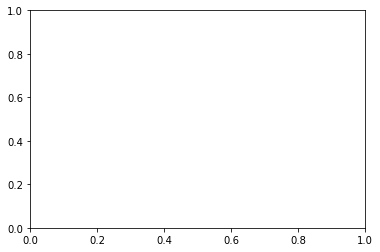

In [34]:
#@test {"skip": true}
print(1)
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)





create_policy_eval_video(agent.policy, "trained-agent")

For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [ ]:
create_policy_eval_video(random_policy, "random-agent")